In [1]:
%%time

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

import logging
import warnings

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
warnings.filterwarnings("ignore")
    
df = pd.read_excel('LW Raw.xlsx')

CPU times: user 59.8 s, sys: 1.02 s, total: 1min
Wall time: 1min 8s


In [2]:
data = df.copy()

data['GGR'] = data['GGR Real EUR'] + data['GGR Bonus EUR']

In [3]:
data.drop(['Brand'], axis=1).sample(5)

,Date,Account ID,Country,VIP level,Deposits EUR,Net Cash EUR,Bets Real EUR,Bets Bonus EUR,GGR Real EUR,GGR Bonus EUR,GGR
246004,2023-06-11,29514713,Germany,1,20.0,20.0,46.14,20.66,20.13,9.83,29.96
223142,2023-05-25,27495277,Hungary,1,0.0,0.0,30.60,0.00,26.73,0.00,26.73
137986,2023-03-11,20491998,Finland,1,20.0,-65.0,391.00,0.00,49.90,0.00,49.90
69091,2023-04-10,14254714,Germany,1,0.0,0.0,38.05,0.00,17.75,0.00,17.75
48022,2023-05-08,11406410,Germany,3,10.0,10.0,23.01,0.04,10.00,0.04,10.04


In [4]:
data.columns

Index(['Brand', 'Date', 'Account ID', 'Country', 'VIP level', 'Deposits EUR',
       'Net Cash EUR', 'Bets Real EUR', 'Bets Bonus EUR', 'GGR Real EUR',
       'GGR Bonus EUR', 'GGR'],
      dtype='object')

In [5]:
# data_1=data.copy()

In [6]:
class LuckyWinner:
    '''
    Class for selecting lucky winners based on given criteria.

    Attributes:
    - PRIZE: The prize amount for each winner.
    - STD: The standard deviation used in upper border detection.
    - WINNERS_COUNT: A dictionary mapping group names to the number of winners for each group.
    - GROUP_WEIGHTS: A dictionary mapping group names to their corresponding weights.
    - WEIGHTS: A dictionary mapping different metrics to their weights.
    - MAX_CONSECUTIVE_WINS: The maximum allowed consecutive wins for a user.
    - MIN_CHANCE: The minimum chance for winning (0%).
    - MAX_CHANCE: The maximum chance for winning (10%).

    Methods:
    - __init__(self, data, items=None, k=None, prev_winners=None, consecutive_winners=None, group_name=None, group=None, weights=WEIGHTS, group_weights=GROUP_WEIGHTS): Initializes the LuckyWinner object with given parameters.
    - users(self, df): Removes users with high GGR (Gross Gaming Revenue) metric per day and selects lucky winners based on specified criteria.
    - classification(self, df): Classifies rows of a DataFrame into different groups based on the values in several columns.
    - run_winner_selection(self, df, max_consecutive_wins, min_chance, max_chance): Runs the winner selection process for each date in the given DataFrame.
    - weighted_random_sample(self, items, k, prev_winners, consecutive_winners, group_name): Selects a weighted random sample of winners based on given criteria.
    - select_winners(self, group, prev_winners, consecutive_winners, min_chance, max_chance): Selects winners from a group based on specified criteria.
    - reward_calculation(self, group, prize, weights): Calculates the reward for each user in a group based on specified metrics and weights.
    - reward_adjustment(self, df, group_weights): Adjusts the rewards based on group weights.
    '''
    
    PRIZE = 500 # ROI Effect - very strong
    STD = 0.5
    
    WINNERS_COUNT = {
        'Group 1': 9, # ROI Effect - strong
        'Group 2': 10, # ROI Effect - low/med
        'Group 3': 4, # ROI Effect - low/med
        'Group 4': 2, # ROI Effect - low/med
        'Other': 0
        }

    GROUP_WEIGHTS = {
        'Group 1': 0.5,
        'Group 2': 1,
        'Group 3': 2,
        'Group 4': 2
        }

    WEIGHTS = {
        'sqrt': 0.5, 
        'ln': 0.3, 
        'Z-score': 0.2
        }
    
    MAX_CONSECUTIVE_WINS = 4  # Maximum allowed consecutive wins
    MIN_CHANCE = 0.0  # Minimum chance for winning (0%)
    MAX_CHANCE = 0.1  # Maximum chance for winning (10%)
    
    
    
    def __init__ (self, data,
                  items=None, k=None, prev_winners=None, consecutive_winners=None, group_name=None,
                  group=None, weights=WEIGHTS, group_weights=GROUP_WEIGHTS):
        '''
        Initializes the LuckyWinner object.

        Parameters:
        - data: The data used for the winner selection process.
        - items: A list of items to select winners from.
        - k: The number of winners to select.
        - prev_winners: A list of previous winners.
        - consecutive_winners: A dictionary mapping user IDs to the number of consecutive wins.
        - group_name: The name of the group.
        - group: The group information.
        - weights: A dictionary mapping different metrics to their weights.
        - group_weights: A dictionary mapping group names to their corresponding weights.
        '''
        
        self.data = data
        self.items = items
        self.k = k
        self.prev_winners = prev_winners
        self.consecutive_winners = consecutive_winners
        self.group_name = group_name
        self.group = group
        self.weights = weights
        self.group_weights = group_weights
        
        self.std = LuckyWinner.STD
        self.prize = LuckyWinner.PRIZE
        self.min_chance = LuckyWinner.MIN_CHANCE
        self.max_chance = LuckyWinner.MAX_CHANCE
        self.max_consecutive_wins = LuckyWinner.MAX_CONSECUTIVE_WINS

        
      
    def users(self, df):
        '''
        Removes users with high GGR (Gross Gaming Revenue) metric per day and selects lucky winners based on specified criteria.

        Parameters:
        - df: Input dataframe. Expected to have at least the columns 'date', 'account_id', and 'GGR'.

        Returns:
        - result: Output dataframe, containing the account_id, date, and sum of GGR for each user and day,
                  excluding users with a high GGR metric. The 'date' column added in the final output corresponds
                  to the date for which the metrics were calculated.
        '''

        final_dataframes = []

        # Taking all availiable dates
        dates = np.sort(df['Date'].unique())

        # Iterating through each date
        for date in dates:

            # Filtering out dataframe by particular date
            daily_df = df[df['Date'] == date].copy()

            # Creating 2 groups to identify outliers (2.5% from each side)
            daily_df['lower'] = np.where(daily_df['GGR'] < (np.quantile(daily_df['GGR'], 0.025)), 1, 0)
            daily_df['upper'] = np.where(daily_df['GGR'] > (np.quantile(daily_df['GGR'], 0.975)), 1, 0)

            # Removing Outliers (users in groups lower and upper)
            daily_outliers = daily_df[(daily_df['lower']==0) & (daily_df['upper']==0)]

            # Calculating mean, sts, and border for each day
            outliers_mean = daily_outliers['GGR'].mean()
            outliers_std = daily_outliers['GGR'].std()
            outliers_border = outliers_mean + outliers_std * self.std

            # Removing users with daily total GGR value greater than the border value
            daily_final = daily_df[daily_df['GGR'] < outliers_border]
            daily_final = daily_final.drop('upper', axis=1)
            daily_final['Date'] = date
            daily_final['mean'] = outliers_mean

            # Append modified daily data to the dataframe
            final_dataframes.append(daily_final)

        # Concatenating all results into one dataframe
        result = pd.concat(final_dataframes)
        result = result[['Date', 'Account ID', 'GGR', 'Net Cash EUR', 'VIP level', 'mean', 'lower']]
        
        # Apply the classification method to create the 'group' column
        result['group'] = result.apply(self.classification, axis=1)
        
        df_winners = self.run_winner_selection(result, self.max_consecutive_wins, self.min_chance, self.max_chance)
        
        winners = df_winners.groupby('Date', group_keys=True).apply(lambda group: self.reward_calculation(group, LuckyWinner.PRIZE, LuckyWinner.WEIGHTS)).reset_index(drop=True)
        
        adjusted_winners = self.reward_adjustment(winners, LuckyWinner.GROUP_WEIGHTS, LuckyWinner.PRIZE)
        adjusted_winners = adjusted_winners[['Date', 'Account ID', 'GGR', 'Net Cash EUR', 'VIP level', 'group', 'reward', 'adjusted_reward', 'final_reward']]
        return adjusted_winners
    
    
    
    def classification(self, df):
        '''
        Classifies rows of a DataFrame into different groups based on the values in several columns.

        Parameters:
        - df: The DataFrame to classify.

        Returns:
        - group: The group name assigned to the row.
        '''

        # Creating conditions for each group
        if df['GGR'] > df['mean']:
            return 'Group 1'
        elif df['GGR'] >= 0: 
            return 'Group 2'
        elif (df['GGR'] < 0) & (df['lower'] != 1):
            return 'Group 3'
        elif (df['GGR'] < 0) & (df['lower'] == 1) & (df['VIP level'] != 1):
            return 'Group 4'
        else:
            return 'Other'
        
        
        
    def run_winner_selection(self, df, max_consecutive_wins, min_chance, max_chance):
        '''
        Runs the winner selection process for each date in the given DataFrame.

        Parameters:
        - df: The DataFrame containing the data for winner selection.
        - max_consecutive_wins: The maximum allowed consecutive wins for a user.
        - min_chance: The minimum chance for winning (0%).
        - max_chance: The maximum chance for winning (10%).

        Returns:
        - df_winners: The DataFrame containing the selected winners.
        '''
        
        df_winners = pd.DataFrame()
        consecutive_winners = {id: 0 for id in df['Account ID'].unique()}
        prev_winners = []
        
        # Iterate over unique dates in the dataframe
        for date in sorted(df['Date'].unique()):
            # Filter the dataframe for the current date
            daily_df = df[df['Date'] == date]
            # Exclude outliers from the winners selection process
            daily_df_filtered = daily_df[daily_df['group'] != 'Other']
            # Group the filtered data by date and group and apply the winners selection function
            daily_winners = daily_df_filtered.groupby(['Date', 'group']).apply(lambda group: self.select_winners(group, prev_winners, consecutive_winners, min_chance, max_chance)).reset_index(drop=True)
            winners_df = daily_winners[['Date', 'Account ID', 'GGR', 'Net Cash EUR', 'group', 'VIP level']]
            
            # Print winners for the current date if any
            if not winners_df.empty:
                # logging.info(f"\nWinners for {date}:")
                # logging.info(winners_df)
                prev_winners = winners_df['Account ID'].tolist()
                df_winners = pd.concat([df_winners, winners_df])
                
        return df_winners
    
    
    
    def weighted_random_sample(self, items, k, prev_winners, consecutive_winners, group_name):
        '''
        Selects a weighted random sample of winners based on given criteria.

        Parameters:
        - items: The list of items to select winners from.
        - k: The number of winners to select.
        - prev_winners: A list of previous winners.
        - consecutive_winners: A dictionary mapping user IDs to the number of consecutive wins.
        - group_name: The name of the group.

        Returns:
        - winners: The list of selected winners.
        '''
        
        weights = []
        for item in items:
            weight = 1.0
            if item in prev_winners and consecutive_winners[item] < self.max_consecutive_wins:
                weight += random.uniform(0.0, self.max_chance)
            elif item not in consecutive_winners or group_name == 'Outliers':
                weight += random.uniform(0.0, self.max_chance)
            weights.append(weight)
        weights /= np.sum(weights)  # Normalize weights to sum up to 1
        winners_indices = np.random.choice(len(items), size=k, replace=False, p=weights)
        winners = [items[idx] for idx in winners_indices]
        return winners
    
    
    
    def select_winners(self, group, prev_winners, consecutive_winners, min_chance, max_chance):
        '''
        Selects winners from a group based on specified criteria.

        Parameters:
        - group: The group to select winners from.
        - prev_winners: A list of previous winners.
        - consecutive_winners: A dictionary mapping user IDs to the number of consecutive wins.
        - min_chance: The minimum chance for winning (0%).
        - max_chance: The maximum chance for winning (10%).

        Returns:
        - group: The DataFrame containing the selected winners from the group.
        '''
        
        group_name = group.name[1]
        account_ids = group['Account ID'].tolist()  # Please, ensure that 'Account ID' is the correct column name in your DataFrame.
        # winners_count_group needs to be calculated or passed as an argument
        winners_count_group = min(self.WINNERS_COUNT[group_name], len(account_ids))
        winners = self.weighted_random_sample(account_ids, winners_count_group, prev_winners, consecutive_winners, group_name)
        for winner_id in winners:
            if winner_id in prev_winners:
                # Determine the win chance for a previous winner
                win_chance = random.uniform(min_chance, max_chance)
                if random.random() < win_chance and consecutive_winners[winner_id] < self.max_consecutive_wins:
                    consecutive_winners[winner_id] += 1
                    # logging.info(f"On {group.name[0]}, User {winner_id} is a winner {consecutive_winners[winner_id]} days in a row!")
            elif winner_id not in consecutive_winners or group_name == 'Outliers':
                # Determine the win chance for an inactive winner or an outlier winner
                win_chance = random.uniform(min_chance, max_chance)
                # if random.random() < win_chance:
                #     if winner_id not in consecutive_winners:
                #         logging.info(f"On {group.name[0]}, User {winner_id} is an inactive winner!")
                #     elif group_name == 'Outliers':
                #         logging.info(f"On {group.name[0]}, User {winner_id} from Outliers group is a winner!")
        return group[group['Account ID'].isin(winners)]
    
    
    
    def reward_calculation(self, group, prize, weights):
        '''
        Calculates the reward for each user in a group based on specified metrics and weights.

        Parameters:
        - group: The group to calculate rewards for.
        - prize: The prize amount for each winner.
        - weights: A dictionary mapping metrics to their weights.

        Returns:
        - group: The group DataFrame with calculated rewards.
        '''
    
        group['sqrt'] = np.sqrt(abs(group['GGR']))
        group['ln'] = np.log(abs(group['GGR']) + 1e-6)
        group['Z-score'] = abs((group['GGR'] - group['GGR'].mean()) / group['GGR'].std())

        for metric in ['Z-score', 'sqrt', 'ln']:
            group[f'{metric}-val'] = group[metric] / group[metric].sum() * prize
        
        group['reward'] = abs(round(sum(group[col+'-val'] * weights[col] for col in weights.keys()), 2))
        reward_sum = group['reward'].sum()

        return group
    
    
    
    def reward_adjustment(self, df, group_weights, prize):
        '''
        Adjusts the rewards based on group weights.

        Parameters:
        - df: The DataFrame containing the rewards.
        - group_weights: A dictionary mapping group names to their corresponding weights.

        Returns:
        - df: The DataFrame with adjusted rewards.
        '''
        
        df['adjusted_reward'] = df['reward'].copy()  # Create a new column with original rewards

        for group, weight in group_weights.items():
            # Apply the weight only to the rows of the specific group
            df.loc[df['group'] == group, 'adjusted_reward'] *= weight

        for date in np.sort(df['Date'].unique()):
            # Create a mask for the current date
            date_mask = df['Date'] == date

            adjusted_reward_sum = df.loc[date_mask, 'adjusted_reward'].sum()
            reward_sum = df.loc[date_mask, 'reward'].sum()

            # Normalize the 'adjusted_reward' so they sum up to prize
            df.loc[date_mask, 'adjusted_reward'] = prize * df.loc[date_mask, 'adjusted_reward'] / adjusted_reward_sum

            # Ensure the adjusted reward is not lower than the original reward
            df.loc[date_mask, 'adjusted_reward'] = df.loc[date_mask, ['adjusted_reward', 'reward']].max(axis=1)

            df.loc[date_mask, 'final_reward'] = df.loc[date_mask, 'adjusted_reward'] - ((df.loc[date_mask, 'reward'] / reward_sum) * (adjusted_reward_sum - prize))

            # Normalize 'final_reward' so the total per date sums up to prize
            df.loc[date_mask, 'final_reward'] = round(prize * df.loc[date_mask, 'final_reward'] / df.loc[date_mask, 'final_reward'].sum(), 2)

        return df

In [7]:
%%time

lw = LuckyWinner(data)
result = lw.users(data)  

date = '2023-01-01' 

new_r = result[result['Date'] == date]

display(new_r[['Date', 'Account ID', 'GGR', 'Net Cash EUR', 'VIP level', 'group', 'final_reward']])
print(f"reward: {new_r['reward'].sum()}")
print(f"adjusted reward: {new_r['adjusted_reward'].sum()}")
print(f"final reward: {new_r['final_reward'].sum()}")
print(f"net cash: {new_r['Net Cash EUR'].sum()}")

,Date,Account ID,GGR,Net Cash EUR,VIP level,group,final_reward
0,2023-01-01,6926849,70.00,0.00,3,Group 1,15.83
1,2023-01-01,9376246,114.94,95.00,3,Group 1,19.64
2,2023-01-01,15556525,75.95,76.00,3,Group 1,16.39
3,2023-01-01,16426153,74.68,0.00,1,Group 1,16.27
4,2023-01-01,19515889,97.01,20.00,1,Group 1,18.22
5,2023-01-01,19599345,99.57,200.00,4,Group 1,18.43
6,2023-01-01,20409662,80.30,80.00,1,Group 1,16.79
7,2023-01-01,24749755,117.41,-7.49,1,Group 1,19.83
8,2023-01-01,24814075,99.93,50.00,1,Group 1,18.46
9,2023-01-01,7723770,10.00,40.00,3,Group 2,7.01


reward: 575.79
adjusted reward: 678.4713465328591
final reward: 500.02
net cash: 1223.2199999999998
CPU times: user 6.22 s, sys: 80.7 ms, total: 6.3 s
Wall time: 6.31 s


In [8]:
Net_Cash = result['Net Cash EUR'].sum()
Reward = result['final_reward'].sum()
ROI = (Net_Cash - Reward) / Reward

print(f'Lucky Winner ROI = {round(ROI * 100, 2)}%')
print(f'Total Given Reward = {round(Reward, 2)}')
print(f'Total Winners Net_Cash = {round(Net_Cash, 2)}')

Lucky Winner ROI = 47.76%
Total Given Reward = 88499.97
Total Winners Net_Cash = 130767.86


In [9]:
groups = result.groupby('group').agg({'Net Cash EUR': 'sum',
                                      'final_reward': 'sum'}).reset_index()

groups['roi'] = round((groups['Net Cash EUR'] - groups['final_reward']) / groups['final_reward'] * 100, 2)
groups

,group,Net Cash EUR,final_reward,roi
0,Group 1,85848.34,24710.50,247.42
1,Group 2,25376.02,16011.04,58.49
2,Group 3,14402.73,13763.24,4.65
3,Group 4,5140.77,34015.19,-84.89


In [10]:
%%time

roi_list = []
reward_list = []
net_cash_list = []

for _ in range(100):
    lw = LuckyWinner(data)
    result = lw.users(data)  

    roi_list.append((result['Net Cash EUR'].sum() - result['final_reward'].sum()) / result['final_reward'].sum() * 100)
    reward_list.append(result['final_reward'].sum())
    net_cash_list.append(result['Net Cash EUR'].sum())

average_roi = np.mean(roi_list)
min_roi = min(roi_list)
max_roi = max(roi_list)
average_reward = np.mean(reward_list)
average_net_cash = np.mean(net_cash_list)

# Making sure that no negative ROI is encountered in all simulations
print(f'Average Lucky Winner ROI = {round(average_roi, 2)}%')
print(f'Average Total Given Reward = {round(average_reward, 2)}')
print(f'Average Total Winners Net_Cash = {round(average_net_cash, 2)}')
print(f'max roi = {max_roi}')
print(f'min roi = {min_roi}')

Average Lucky Winner ROI = 46.67%
Average Total Given Reward = 88499.99
Average Total Winners Net_Cash = 129801.43
max roi = 86.38137083693263
min roi = -0.798587029206534
CPU times: user 10min 6s, sys: 6.64 s, total: 10min 13s
Wall time: 10min 14s


In [11]:
# data_1[(data_1['Date']=='2023-01-01')&(data_1['Account ID']==19727649)]

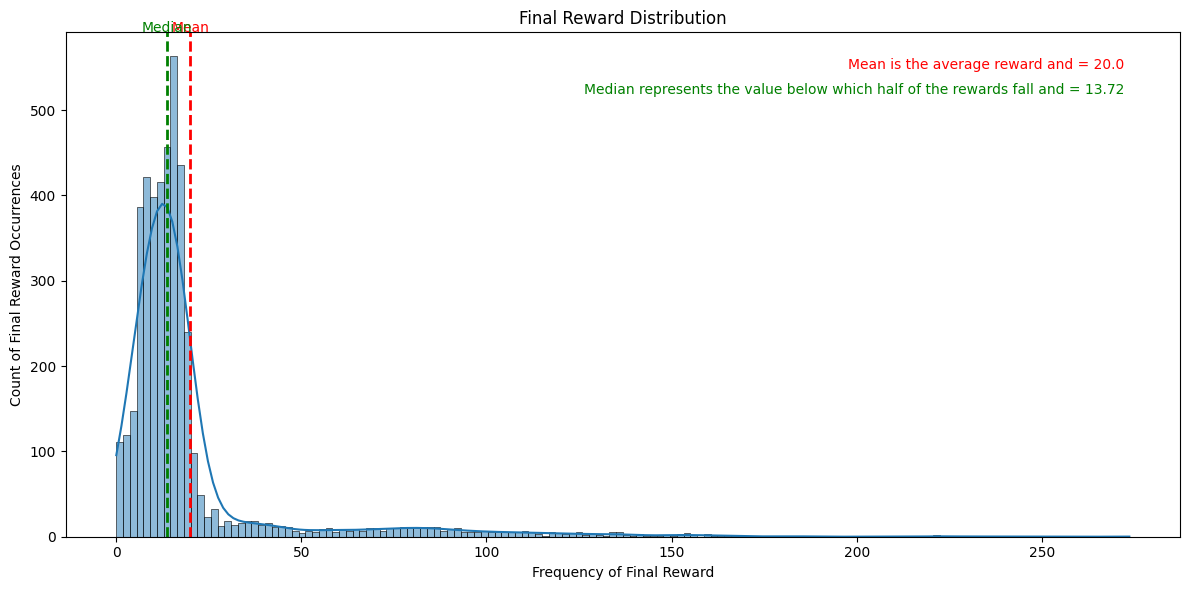

In [12]:
fig = plt.figure()
fig.set_size_inches(12, 6)

sns.histplot(data=result, x='final_reward', bins=150, kde=True)

mean_value = round(result['final_reward'].mean(), 2)
median_value = round(result['final_reward'].median(), 2)

plt.axvline(mean_value, color='r', linestyle='dashed', linewidth=2)
plt.axvline(median_value, color='g', linestyle='dashed', linewidth=2)


plt.text(mean_value, plt.gca().get_ylim()[1], 'Mean', ha='center', color='r')
plt.text(median_value, plt.gca().get_ylim()[1], 'Median', ha='center', color='g')
plt.text(0.95, 0.95, f'Mean is the average reward and = {mean_value}', ha='right', va='top', transform=plt.gca().transAxes, color='r')
plt.text(0.95, 0.9, f'Median represents the value below which half of the rewards fall and = {median_value}', ha='right', va='top', transform=plt.gca().transAxes, color='g')

plt.xlabel('Frequency of Final Reward')
plt.ylabel('Count of Final Reward Occurrences')
plt.title('Final Reward Distribution')

plt.tight_layout()

plt.show()

In [13]:
q = result.copy()
q.reset_index()
w = q.groupby(['Account ID', 'VIP level']).agg({'GGR': 'sum',
                                'final_reward': 'sum',
                                'Account ID': 'count'}).rename(columns={'Account ID': 'count'}).reset_index()

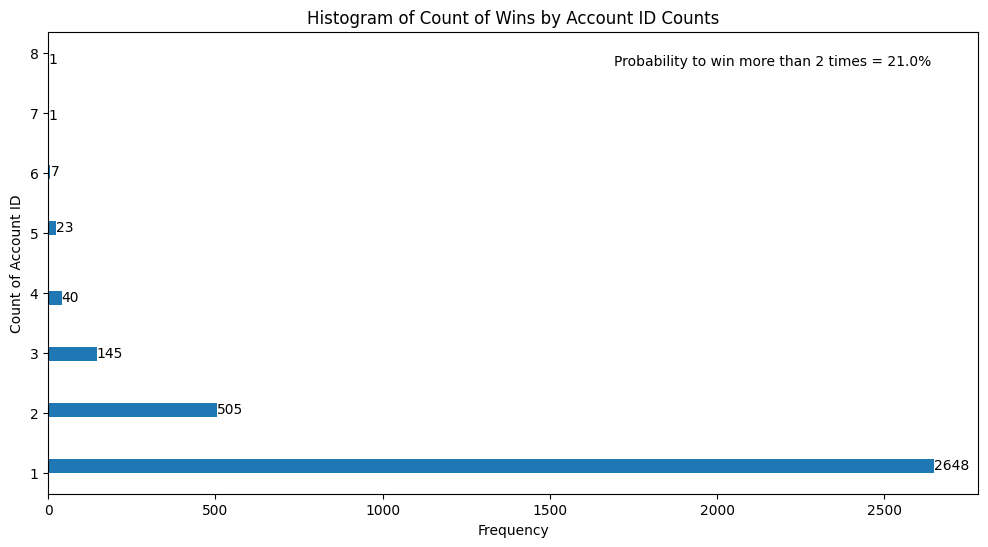

In [14]:
plt.figure(figsize=[12,6])
counts, bins, patches = plt.hist(w['count'], bins=30, orientation='horizontal')

# Label y-axis with bin range
bin_centers = 0.5 * (bins[:-1] + bins[1:])
for count, y, patch in zip(counts, bin_centers, patches):
    # Label the raw counts
    if count > 0:
        plt.text(patch.get_x() + patch.get_width(), patch.get_y() + patch.get_height()/2.,
                 f'{int(count)}', ha='left', va='center')

probability_more_than_1 = round(w[w['count'] > 1]['count'].count() / w['count'].count(), 2) * 100
plt.text(0.95, 0.95, f'Probability to win more than 2 times = {round(probability_more_than_1, 2)}%', ha='right', va='top', transform=plt.gca().transAxes)

# Format and display the plot
plt.xlabel('Frequency')
plt.ylabel('Count of Account ID')
plt.title('Histogram of Count of Wins by Account ID Counts')
plt.show()